In [1]:
import numpy as np
from scipy.linalg import pinv
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
import scipy.linalg as scl

from sklearn.model_selection import train_test_split



import sklearn.linear_model as skl
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV

We start with defining some function we will need later. 

In [2]:
# creates a design matrix for degree n
def CreateDesignMatrix_X(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
        
    N = len(x)
    l = int((n+1)*(n+2)/2)
    X = np.ones((N,l))
        
    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = x**(i-k) * y**k
    return X

In [3]:
# creates a smaller array 
# calculates new value by taking the mean over an array in the original array of 
# size (a.shape[0]/shape[0], a.shape[1]/shape[1])
# https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [4]:
def MSE(z_data, z_model):
    n = np.size(z_model)
    return np.sum((z_data-z_model)**2)/n

In [5]:
def R2(z_data, z_model):
    return 1 - np.sum((z_data - z_model) ** 2) / np.sum((z_data - np.mean(z_model)) ** 2)

## 0. Setting up the data

We start with the visualisation of the data given in the project. 

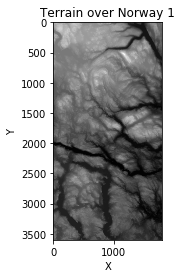

In [6]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
terrain2 = terrain1[:3600, :1800]  #makes it easier to make array smaller
terrain = (terrain2 - np.mean(terrain2)*np.ones(terrain2.shape))/(np.std(terrain2)) #normalize the data 

# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [7]:
#x = np.arange(0, 1800)
#y = np.arange(0, 3600)

x = np.linspace(0, 1, 1800) 
y = np.linspace(0, 1, 3600)

xx, yy = np.meshgrid(x,y)

k = 10 # factor by which each axis will get shorter --> amount of points decreases by k^2
xlr = rebin(xx, (3600//k, 1800//k))
ylr = rebin(yy, (3600//k, 1800//k))
terrain_r = rebin(terrain, (3600//k, 1800//k))


#Transform from matrices to vectors 
x_1 = np.ravel(xlr)
y_1 = np.ravel(ylr)
z_1 = np.ravel(terrain_r)

Here we use k = 10 for dataset 1 (64.000 points) and k = 100 for dataset 2 (648 points)

### Plot of the data

We start with visualizing the data

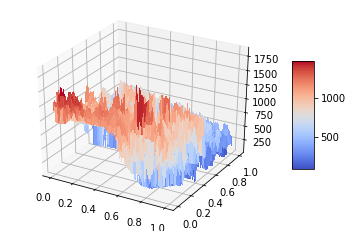

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(xx,yy,terrain2, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

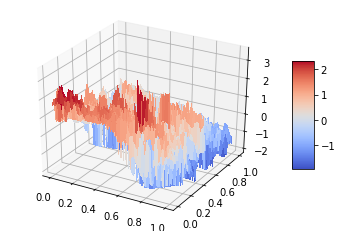

In [9]:
# plot the smaller data
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(xlr,ylr,terrain_r, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## 1. OLS regression

We start with a simple regression to visualize the fit. 

In [10]:
degree = 5

X = CreateDesignMatrix_X(x_1, y_1, n=degree)
beta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(z_1)
ztilde1 = X @ beta

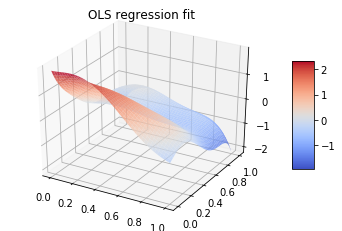

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

ax1.plot_surface(xlr, ylr, ztilde1.reshape(xlr.shape), alpha=0.8, cmap=cm.coolwarm)

plt.colorbar(surf, shrink=0.5, aspect=5)

plt.title(f'OLS regression fit')
plt.show()

Then we split the data into train and test data and create a new model

In [12]:
Xtrain, Xtest, ztrain, ztest = train_test_split(X, z_1, test_size=0.2)

beta = np.linalg.pinv(Xtrain.T.dot(Xtrain)).dot(Xtrain.T).dot(ztrain)
ztilde = Xtrain @ beta
zpred = Xtest @ beta

In [13]:
print('MSE training:', MSE(ztrain, ztilde))
print('MSE test', MSE(ztest, zpred))

print('R2 training:', R2(ztrain, ztilde))
print('R2 test', R2(ztest, zpred))

MSE training: 0.45736213184174546
MSE test 0.4552010736452077
R2 training: 0.5427308748511033
R2 test 0.5306223048466503


### 1.1. K-Fold cross-validation for OLS

Here we set up our k-fold cross-validation function. We can later call the function. 
We use pinv for the matrix inversion.

In [14]:
# Initialize a KFold instance
k = 10
kfold = KFold(n_splits = k, shuffle=True)

In [15]:
def cross_validation(x, y, k):
    n = len(x)
    
    indexes = np.arange(y.shape[0])
    np.random.shuffle(indexes)
    x = x[indexes]
    y = y[indexes]
    
    r2_train = []
    r2_test = []
    mse_train = []
    mse_test = []
    
    bias = []
    variance = []
    for i in range(k):
        x_train = np.concatenate((x[:int(i*n/k)], x[int((i + 1)*n/k): ]), axis = 0)
        x_test = x[int(i*n/k):int((i + 1)*n/k)]
        y_train = np.concatenate((y[:int(i*n/k)], y[int((i + 1)*n/k): ]), axis = 0)
        y_test = y[int(i*n/k):int((i + 1)*n/k)]

        beta = np.linalg.pinv(x_train.T.dot(x_train)).dot(x_train.T).dot(y_train)
        ytilde = x_train @ beta
        ypredict = x_test @ beta
        
        mse_train.append(MSE(y_train, ytilde))
        mse_test.append(MSE(y_test, ypredict))
        
        r2_train.append(R2(y_train, ytilde))
        r2_test.append(R2(y_test, ypredict))
        
        bias.append(np.mean((y_test - np.mean(ypredict))**2))
        variance.append(np.mean(np.var(ypredict)))
    
    r2_train = np.array(r2_train)
    r2_test = np.array(r2_test)
    mse_train = np.array(mse_train)
    mse_test = np.array(mse_test)
    
    bias = np.array(bias)
    variance = np.array(variance)
        
    return r2_test, r2_train, mse_test, mse_train, bias, variance, 

In [16]:
r2_test, r2_train, mse_test, mse_train,_,_ = cross_validation(X, z_1, 10)

print("MSE_train_OLS_CV: %0.5f (+/- %0.5f)" % (mse_train.mean(), mse_train.std() * 2))
print("MSE_test_OLS_CV: %0.5f (+/- %0.5f)" % (mse_test.mean(), mse_test.std() * 2))

print("R2_train_OLS_CV: %0.3f (+/- %0.3f)" % (r2_train.mean(), r2_train.std() * 2))
print("R2_test_OLS_CV: %0.3f (+/- %0.3f)" % (r2_test.mean(), r2_test.std() * 2))

MSE_train_OLS_CV: 0.45687 (+/- 0.00286)
MSE_test_OLS_CV: 0.45722 (+/- 0.02578)
R2_train_OLS_CV: 0.540 (+/- 0.002)
R2_test_OLS_CV: 0.540 (+/- 0.020)


### 1.2. Complexity of the model

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


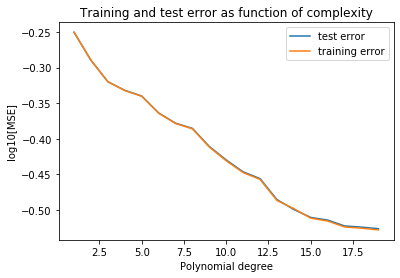

In [17]:
# train and test error

maxdegree = 20

test_mse = np.zeros(maxdegree)
train_mse = np.zeros(maxdegree)
polynomial = np.zeros(maxdegree)

for degree in range(1, maxdegree):
    X1 = CreateDesignMatrix_X(x_1, y_1, n=degree)
        
    polynomial[degree] = degree
    train_mse[degree] = np.mean(cross_validation(X1, z_1, k)[3])
    test_mse[degree] = np.mean(cross_validation(X1, z_1, k)[2])

plt.plot(polynomial, np.log10(test_mse), label='test error')
plt.plot(polynomial, np.log10(train_mse), label='training error')

plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.title('Training and test error as function of complexity')

plt.legend()
plt.show()

### 1.3. Bias-variance tradeoff

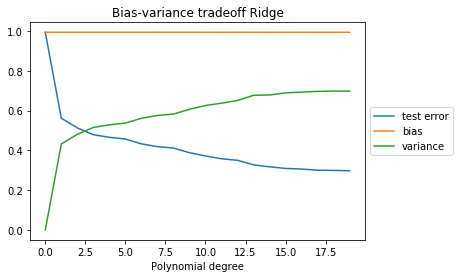

In [18]:
maxdegree = 20
polynomial = np.arange(maxdegree)


error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)

for degree in range(maxdegree):
    X2 = CreateDesignMatrix_X(x_1, y_1, n=degree)  
    X2_train, X2_test, z2_train, z2_test = train_test_split(X2, z_1, test_size=0.2)
    
    error[degree] = np.mean(cross_validation(X2, z_1, k)[2])
    bias[degree] = np.mean(cross_validation(X2, z_1, k)[4])
    variance[degree] = np.mean(cross_validation(X2, z_1, k)[5])

plt.plot(polynomial, error, label = 'test error')
plt.plot(polynomial, bias, label = 'bias')
plt.plot(polynomial, variance, label = 'variance')

#plt.plot(polynomial, np.log10(true_mse), label='error OLS')
plt.title('Bias-variance tradeoff Ridge')
#plt.title('Test error Ridge')
#plt.title('Bias Ridge')
#plt.title('Variance Ridge')

plt.xlabel('Polynomial degree')
#plt.xlim(1,15)
#plt.ylabel('variance')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()   

### New OLS regression with CV

Then we create a new design matrix with the optimal polynomial degree, which in this case is 15 to keep computational expenses at a low. 

In [19]:
degree = 15

X_new = CreateDesignMatrix_X(x_1, y_1, n=degree)
X_new_train, X_new_test, z_train, z_test = train_test_split(X_new, z_1, test_size=0.2)

beta_new = np.linalg.pinv(X_new_train.T.dot(X_new_train)).dot(X_new_train.T).dot(z_train)
ztilde_new = X_new_train @ beta_new
zpred_new = X_new_test @ beta_new

In [20]:
r2_test, r2_train, mse_test, mse_train,_,_ = cross_validation(X_new, z_1, 10)
print("MSE_train_OLS_CV: %0.5f (+/- %0.5f)" % (mse_train.mean(), mse_train.std() * 2))
print("MSE_test_OLS_CV: %0.5f (+/- %0.5f)" % (mse_test.mean(), mse_test.std() * 2))

print("R2_train_OLS_CV: %0.3f (+/- %0.3f)" % (r2_train.mean(), r2_train.std() * 2))
print("R2_test_OLS_CV: %0.3f (+/- %0.3f)" % (r2_test.mean(), r2_test.std() * 2))

MSE_train_OLS_CV: 0.30794 (+/- 0.00320)
MSE_test_OLS_CV: 0.30871 (+/- 0.02047)
R2_train_OLS_CV: 0.690 (+/- 0.003)
R2_test_OLS_CV: 0.689 (+/- 0.020)


## 2. Ridge regression

We start by setting up the expressions for the Ridge regression. 

In [21]:
_lambda = 1e-6

In [22]:
X_train_r, X_test_r = X_new_train, X_new_test

betaridge = np.linalg.inv(X_train_r.T.dot(X_train_r)+(_lambda*np.eye(len(X_train_r[0])))).dot(X_train_r.T).dot(z_train)
zridge = X_train_r @ betaridge

ridge_predict = X_test_r @ betaridge

In [23]:
print('MSE training:', MSE(z_train, zridge))
print('MSE test', MSE(z_test, ridge_predict))
print('R2 training:', R2(z_train, zridge))
print('R2 test', R2(z_test, ridge_predict))

MSE training: 0.37137141841461246
MSE test 0.3722516878851631
R2 training: 0.6262686662529562
R2 test 0.6261804928370844


In [24]:
ridge = skl.Ridge(alpha = _lambda).fit(X_train_r[:,1:], z_train)
pred_R = ridge.predict(X_test_r[:,1:])

print("MSE Ridge SKlearn:", MSE(z_test, pred_R))
print("R2 Ridge SKlearn:", R2(z_test, pred_R))

MSE Ridge SKlearn: 0.37225168582047147
R2 Ridge SKlearn: 0.6261804948971678


### 2.1. Optimal value for lambda

Then we have a look at which $\lambda$ is best, so that we know which value of lambda to use for the ridge regression

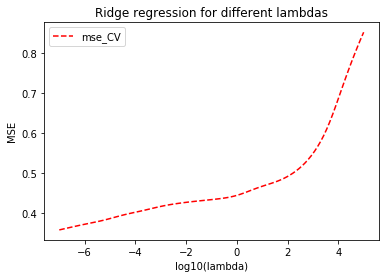

In [25]:
k = 10
kfold = KFold(n_splits = k, shuffle=True)

nlambdas = 100
lambdas = np.logspace(-7, 5, nlambdas)

mse_scores_CV = np.zeros((nlambdas, k))

i = 0
for lmb in lambdas:
    betaridge1 = np.linalg.inv(X_train_r.T.dot(X_train_r)+(lmb*np.eye(len(X_train_r[0])))).dot(X_train_r.T).dot(z_train)
    
    j = 0
    for train_inds, test_inds in kfold.split(X_new):
        Xtrain_r = X_new[train_inds]
        ztrain_r = z_1[train_inds]
        
        Xtest_r = X_new[test_inds]
        ztest_r = z_1[test_inds]
        
        zpred_r = Xtest_r @ betaridge1

        mse_scores_CV[i,j] = MSE(ztest_r, zpred_r)

        j += 1
    i += 1

estimated_mse_CV = np.mean(mse_scores_CV, axis = 1)

plt.figure()
plt.plot(np.log10(lambdas), estimated_mse_CV, 'r--', label = 'mse_CV')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.title('Ridge regression for different lambdas')
plt.legend()
plt.show()

And we compare it with sk-learn

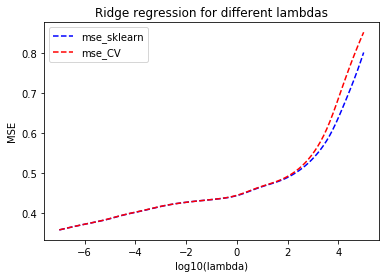

In [26]:
estimated_mse_sklearn = np.zeros(nlambdas)

i = 0
for lmb in lambdas:
    ridge = skl.Ridge(alpha = lmb)

    estimated_mse_folds = cross_val_score(ridge, X_new[:,1:], z_1, scoring='neg_mean_squared_error', cv=kfold)
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)
    i += 1

plt.figure()

plt.plot(np.log10(lambdas), estimated_mse_sklearn, 'b--', label = 'mse_sklearn')
plt.plot(np.log10(lambdas), estimated_mse_CV, 'r--', label = 'mse_CV')

plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.title('Ridge regression for different lambdas')
plt.legend()
plt.show()

We use GridSearchCV to find the optimal value for lambda. 

In [27]:
nlambdas = 50
lambdas = np.logspace(-7, 2, nlambdas)

param_grid = {'alpha': lambdas}

ridge = skl.Ridge()

ridge_regressor = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=kfold)
ridge_regressor.fit(X_new[:,1:], z_1)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 1e-07}
-0.35723231703596575


### 2.2. Ridge as function of model complexity

We first create a new function to get the cross-validation for Ridge

In [28]:
def cross_validation_ridge(x, y, lmb, k):
    n = len(x)
    
    indexes = np.arange(y.shape[0])
    np.random.shuffle(indexes)
    x = x[indexes]
    y = y[indexes]
    
    r2_train = []
    r2_test = []
    mse_train = []
    mse_test = []
    
    bias = []
    variance = []
    for i in range(k):
        x_train = np.concatenate((x[:int(i*n/k)], x[int((i + 1)*n/k): ]), axis = 0)
        x_test = x[int(i*n/k):int((i + 1)*n/k)]
        y_train = np.concatenate((y[:int(i*n/k)], y[int((i + 1)*n/k): ]), axis = 0)
        y_test = y[int(i*n/k):int((i + 1)*n/k)]

        beta = np.linalg.inv(x_train.T.dot(x_train)+(lmb*np.eye(len(x_train[0])))).dot(x_train.T).dot(y_train)

        ytilde = x_train @ beta
        ypredict = x_test @ beta
        
        mse_train.append(MSE(y_train, ytilde))
        mse_test.append(MSE(y_test, ypredict))
        
        r2_train.append(R2(y_train, ytilde))
        r2_test.append(R2(y_test, ypredict))
        
        bias.append(np.mean((y_test - np.mean(ypredict))**2))
        variance.append(np.mean(np.var(ypredict)))
    
    r2_train = np.array(r2_train)
    r2_test = np.array(r2_test)
    mse_train = np.array(mse_train)
    mse_test = np.array(mse_test)
    
    bias = np.array(bias)
    variance = np.array(variance)
        
    return r2_test, mse_train, mse_test, bias, variance, r2_train

And then we can plot the MSE-score against the complexity, for different values of lambda

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


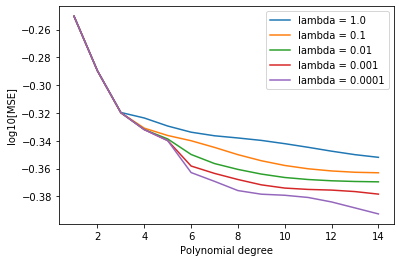

In [29]:
maxdegree = 15
polynomial = np.arange(maxdegree)

_lambdas = [1.0, 0.1, 0.01, 0.001, 0.0001]

CV_mse_ridge = np.zeros((maxdegree, len(_lambdas)))
CV_mse_OLS = np.zeros(maxdegree)

for degree in range(1, maxdegree):
    XR = CreateDesignMatrix_X(x_1, y_1, n=degree)  
    CV_mse_OLS[degree] = np.mean(cross_validation(X_new, z_1, k)[2])
    
    XR_train, XR_test, zR_train, zR_test = train_test_split(XR, z_1, test_size=0.2)
    
    for i in range(len(_lambdas)):       
        CV_mse_ridge[degree, i] = np.mean(cross_validation_ridge(XR, z_1, _lambdas[i], k)[2])


for i in range(len(_lambdas)):
    plt.plot(polynomial, np.log10(CV_mse_ridge[:,i]), label='lambda = {}'.format(_lambdas[i]))

#plt.plot(polynomial, np.log10(CV_mse_OLS), label='error OLS')    
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
#plt.title('Ridge regression')
plt.legend()
plt.show()   

### 5.3. Bias-variance and ridge

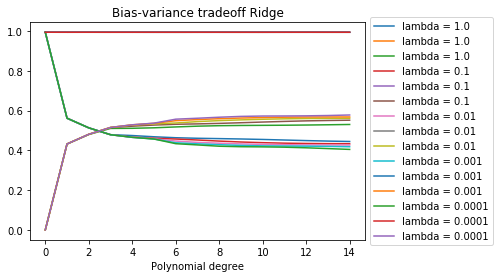

In [30]:
maxdegree = 15
polynomial = np.arange(maxdegree)


_lambdas = [1.0, 0.1, 0.01, 0.001, 0.0001]

error_ridge = np.zeros((maxdegree, len(_lambdas)))
bias_ridge = np.zeros((maxdegree, len(_lambdas)))
variance_ridge = np.zeros((maxdegree, len(_lambdas)))

for degree in range(maxdegree):
    XR1 = CreateDesignMatrix_X(x_1, y_1, n=degree)  
    XR1_train, XR1_test, zR1_train, zR1_test = train_test_split(XR1, z_1, test_size=0.2)
    
    for i in range(len(_lambdas)):       
        error_ridge[degree, i] = np.mean(cross_validation_ridge(XR1, z_1, _lambdas[i], k)[2])
        bias_ridge[degree, i] = np.mean(cross_validation_ridge(XR1, z_1, _lambdas[i], k)[3])
        variance_ridge[degree, i] = np.mean(cross_validation_ridge(XR1, z_1, _lambdas[i], k)[4])

for i in range(len(_lambdas)):
    plt.plot(polynomial, error_ridge[:,i], label='lambda = {}'.format(_lambdas[i]))
    plt.plot(polynomial, bias_ridge[:,i], label='lambda = {}'.format(_lambdas[i]))
    plt.plot(polynomial, variance_ridge[:,i], label='lambda = {}'.format(_lambdas[i]))

#plt.plot(polynomial, np.log10(true_mse), label='error OLS')
plt.title('Bias-variance tradeoff Ridge')
#plt.title('Test error Ridge')
#plt.title('Bias Ridge')
#plt.title('Variance Ridge')

plt.xlabel('Polynomial degree')
#plt.xlim(1,15)
#plt.ylabel('variance')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()   

##### Final settings and scores for ridge

In [31]:
lmb_ridge = 0.001

mse_train_ridge = cross_validation_ridge(X_new[:,1:], z_1, lmb_ridge, k)[1]
mse_test_ridge = cross_validation_ridge(X_new[:,1:], z_1, lmb_ridge, k)[2]

r2_train_ridge = cross_validation_ridge(X_new[:,1:], z_1, lmb_ridge, k)[5]
r2_test_ridge = cross_validation_ridge(X_new[:,1:], z_1, lmb_ridge, k)[0]

ridge = skl.Ridge(alpha = lmb_ridge)
mse_ridge_sklearn = cross_val_score(ridge, X_new[:,1:], z_1, scoring='neg_mean_squared_error', cv=kfold)

print("MSE train ridge: %0.5f (+/- %0.5f)" % (mse_train_ridge.mean(), mse_train_ridge.std()*2))
print("MSE test ridge: %0.5f (+/- %0.5f)" % (mse_test_ridge.mean(), mse_test_ridge.std()*2))

print("MSE ridge SKLearn: %0.5f (+/- %0.5f)" % (-(mse_ridge_sklearn.mean()), mse_ridge_sklearn.std()*2))

print("R2 train ridge: %0.5f (+/- %0.5f)" % (r2_train_ridge.mean(), r2_train_ridge.std()*2))
print("R2 test ridge: %0.5f (+/- %0.5f)" % (r2_test_ridge.mean(), r2_test_ridge.std()*2))

MSE train ridge: 0.42832 (+/- 0.00166)
MSE test ridge: 0.42885 (+/- 0.01048)
MSE ridge SKLearn: 0.41592 (+/- 0.01494)
R2 train ridge: 0.56915 (+/- 0.00165)
R2 test ridge: 0.56856 (+/- 0.01495)


## 3. Lasso regression

We start by making the same plot as for ridge, to see how the MSE depends on lambda

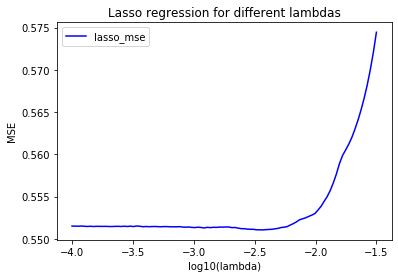

In [32]:
nlambdas = 100
lambdas = np.logspace(-4, -1.5, nlambdas)

lasso_mse = np.zeros(nlambdas)

i = 0
for lmb in lambdas:
    lasso = skl.Lasso(alpha = lmb, precompute = True, tol = 10, max_iter = 10e3)

    lasso_mse_folds = cross_val_score(lasso, X_new[:,1:], z_1, scoring='neg_mean_squared_error', cv=kfold)
    lasso_mse[i] = np.mean(-lasso_mse_folds)
    i += 1

plt.figure()
plt.plot(np.log10(lambdas), lasso_mse, 'b', label = 'lasso_mse')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.title('Lasso regression for different lambdas')
plt.legend()
plt.show()

Then we find the optimal value for lambda for lasso, using GridSearchCV

In [33]:
nlambdas = 50
lambdas_lasso = np.logspace(-7, 2, nlambdas)
param_grid_lasso = {'alpha': lambdas_lasso}

lasso = skl.Lasso(precompute = True, tol = 10, max_iter = 10e3)

lasso_regressor = GridSearchCV(lasso, param_grid_lasso, scoring='neg_mean_squared_error', cv=kfold)
lasso_regressor.fit(X_new[:,1:], z_1)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 0.003906939937054621}
-0.5511017345297556


### 3.1. LASSO as function of model complexity

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


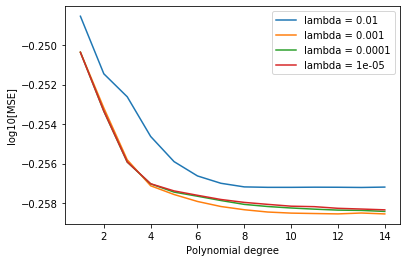

In [34]:
maxdegree = 15
polynomial = np.arange(maxdegree)

_lambdas = [0.01, 0.001, 0.0001, 0.00001]

CV_mse_lasso = np.zeros((maxdegree, len(_lambdas)))
CV_mse_OLS = np.zeros(maxdegree)

for degree in range(1, maxdegree):
    XL = CreateDesignMatrix_X(x_1, y_1, n=degree)  
    CV_mse_OLS[degree] = np.mean(cross_validation(X_new, z_1, k)[2])
    
    XL_train, XL_test, zL_train, zL_test = train_test_split(XL, z_1, test_size=0.2)
    
    for i in range(len(_lambdas)): 
        lasso = skl.Lasso(alpha = _lambdas[i], precompute = True, tol = 10, max_iter = 10e3)
        CV_mse_lasso[degree, i] = -np.mean(cross_val_score(lasso, XL[:,1:], z_1, scoring='neg_mean_squared_error', cv=kfold))

for i in range(len(_lambdas)):
    plt.plot(polynomial, np.log10(CV_mse_lasso[:,i]), label='lambda = {}'.format(_lambdas[i]))

#plt.plot(polynomial, np.log10(CV_mse_OLS), label='error OLS')    
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
#plt.title('Ridge regression')
plt.legend()
plt.show()   

Then we implement this lambda

In [35]:
l_lambda = 0.005

clf_lasso = skl.Lasso(alpha=l_lambda, precompute = True, tol = 10, max_iter = 10e3).fit(X_new_train, z_train)
pred_lasso = clf_lasso.predict(X_new_test)


lasso_mse_folds = cross_val_score(clf_lasso, X_new[:,1:], z_1, scoring='neg_mean_squared_error', cv=kfold)
lasso_mse = np.mean(-lasso_mse_folds)

lasso_r2_folds = cross_val_score(clf_lasso, X_new[:,1:], z_1, cv=kfold)
lasso_r2 = np.mean(-lasso_r2_folds)

## 4. Comparing of models 

And now we can compare the three models with eachother, including **cross validation for all models**

In [36]:
#print("MSE_train_OLS_CV: %0.5f (+/- %0.5f)" % (mse_train.mean(), mse_train.std() * 2))
print("MSE_test_OLS_CV: %0.5f (+/- %0.5f)" % (mse_test.mean(), mse_test.std() * 2))

#print("MSE train ridge: %0.5f (+/- %0.5f)" % (mse_train_ridge.mean(), mse_train_ridge.std()*2))
print("MSE test ridge: %0.5f (+/- %0.5f)" % (mse_test_ridge.mean(), mse_test_ridge.std()*2))

print("MSE test LASSO: %0.5f (+/- %0.5f)" % (-(lasso_mse_folds.mean()), lasso_mse_folds.std()*2))

MSE_test_OLS_CV: 0.30871 (+/- 0.02047)
MSE test ridge: 0.42885 (+/- 0.01048)
MSE test LASSO: 0.55130 (+/- 0.01648)


In [37]:
#print("R2_train_OLS_CV: %0.3f (+/- %0.3f)" % (r2_train.mean(), r2_train.std() * 2))
print("R2_test_OLS_CV: %0.3f (+/- %0.3f)" % (r2_test.mean(), r2_test.std() * 2))

#print("R2 train ridge: %0.5f (+/- %0.5f)" % (r2_train_ridge.mean(), r2_train_ridge.std()*2))
print("R2 test ridge: %0.5f (+/- %0.5f)" % (r2_test_ridge.mean(), r2_test_ridge.std()*2))


print("R2 LASSO: %0.5f (+/- %0.5f)" % (lasso_r2_folds.mean(), lasso_r2_folds.std()*2))

R2_test_OLS_CV: 0.689 (+/- 0.020)
R2 test ridge: 0.56856 (+/- 0.01495)
R2 LASSO: 0.44534 (+/- 0.01204)
